<a href="https://colab.research.google.com/github/ok-tsar/VandyHacks_Heartbeat_Classification/blob/main/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/'My Drive'/'VandyHacks'

/content/gdrive/My Drive/VandyHacks


In [3]:
# library import
import torch
from collections import Counter
import plotly.express as px
from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, sampler
from torchvision import models
import torch.nn as nn
from torch.nn.functional import interpolate
from torch import optim, cuda, Tensor
import tqdm
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import os
from PIL import Image
from timeit import default_timer as timer
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
# define paths
traindir_librosa = f"./data_librosa_png/train"
validdir_librosa = f"./data_librosa_png/valid"
traindir_chroma = f"./data_chroma_png/train"
validdir_chroma = f"./data_chroma_png/valid"
traindir_mfcc = f"./data_mfcc_png/train"
validdir_mfcc = f"./data_mfcc_png/valid"

save_file_librosa = f'./trained_models/lib.pt'
save_file_chroma = f'./trained_models/chr.pt'
save_file_mfcc = f'./trained_models/mfcc.pt'

# set batch size
batch_size = 20

In [22]:
# switch to gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)



Train on gpu: True
1 gpus detected.
True False


In [7]:
# check that we can load image
#ex_img = Image.open('./data_librosa_png/train/murmur/1.png')
#ex_img

In [8]:
# define image transformations/normalization
image_transforms = {
    'train':
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
        ]),
    'valid':
        transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
}

In [9]:
# draw data
data = {
    'train_librosa':
    datasets.ImageFolder(root=traindir_librosa,  transform=image_transforms['train']),
    'valid_librosa':
    datasets.ImageFolder(root=validdir_librosa, transform=image_transforms['valid']),

    'train_chroma':
    datasets.ImageFolder(root=traindir_chroma,  transform=image_transforms['train']),
    'valid_chroma':
    datasets.ImageFolder(root=validdir_chroma, transform=image_transforms['valid']),

    'train_mfcc':
    datasets.ImageFolder(root=traindir_mfcc,  transform=image_transforms['train']),
    'valid_mfcc':
    datasets.ImageFolder(root=validdir_mfcc, transform=image_transforms['valid'])
}

# dataloader iterators with shuffle
dataloaders = {
    'train_librosa': DataLoader(data['train_librosa'], batch_size=batch_size, shuffle=True,num_workers=0),
    'val_librosa': DataLoader(data['valid_librosa'], batch_size=batch_size, shuffle=True,num_workers=0),

    'train_chroma': DataLoader(data['train_chroma'], batch_size=batch_size, shuffle=True,num_workers=0),
    'val_chroma': DataLoader(data['valid_chroma'], batch_size=batch_size, shuffle=True,num_workers=0),

    'train_mfcc': DataLoader(data['train_mfcc'], batch_size=batch_size, shuffle=True,num_workers=0),
    'val_mfcc': DataLoader(data['valid_mfcc'], batch_size=batch_size, shuffle=True,num_workers=0)
}

# iterateing through the dataloader once
trainiter = iter(dataloaders['train_librosa'])
features, labels = next(trainiter)
#features.shape, labels.shape

# extracting possible catagories
categories = []
for d in os.listdir(traindir_librosa):
    categories.append(d)

n_classes = len(categories)
print(f'There are {n_classes} different classes.')
print(categories)

There are 4 different classes.
['artifact', 'murmur', 'normal', 'extra']


In [10]:
# defining three resnext models (librosa(ie. spectrogram), chroma, and mfcc)
model_librosa = models.resnext101_32x8d(pretrained=True)
model_chroma = models.resnext101_32x8d(pretrained=True)
model_mfcc = models.resnext101_32x8d(pretrained=True)

# Freezeing model weights
for param in model_librosa.parameters():
    param.requires_grad = False
#for parameter in model_librosa[-1].parameters():
#    parameter.requires_grad = True

for param in model_chroma.parameters():
    param.requires_grad = False
#for parameter in model_chroma[-1].parameters():
#    parameter.requires_grad = True

for param in model_mfcc.parameters():
    param.requires_grad = False
#for parameter in model_mfcc[-1].parameters():
#    parameter.requires_grad = True


# librosa (spectrogram) model
n_inputs_librosa = model_librosa.fc.in_features
# choosing spectrogram model params
model_librosa.fc = nn.Sequential(
                      nn.Linear(n_inputs_librosa, 256),
                      nn.ELU(),
                      nn.Dropout(0.05),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))
model_librosa.fc

total_params_librosa = sum(p.numel() for p in model_librosa.parameters())
print(f'{total_params_librosa:,} total parameters.')
total_trainable_params_librosa = sum(
    p.numel() for p in model_librosa.parameters() if p.requires_grad)
print(f'{total_trainable_params_librosa:,} training parameters.')


# chroma model
n_inputs_chroma = model_chroma.fc.in_features
# choosing chroma model params
model_chroma.fc = nn.Sequential(
                      nn.Linear(n_inputs_chroma, 256),
                      nn.ReLU(),
                      nn.Dropout(0.25),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))
model_chroma.fc

total_params_chroma = sum(p.numel() for p in model_chroma.parameters())
print(f'{total_params_chroma:,} total parameters.')
total_trainable_params_chroma = sum(
    p.numel() for p in model_chroma.parameters() if p.requires_grad)
print(f'{total_trainable_params_chroma:,} training parameters.')


# mfcc model
n_inputs_mfcc = model_mfcc.fc.in_features
# choosing mfcc model params
model_mfcc.fc = nn.Sequential(
                      nn.Linear(n_inputs_mfcc, 256),
                      nn.ELU(),
                      nn.Dropout(0.05),
                      nn.Linear(256, n_classes),
                      nn.LogSoftmax(dim=1))

model_mfcc.fc

total_params_mfcc = sum(p.numel() for p in model_mfcc.parameters())
print(f'{total_params_mfcc:,} total parameters.')
total_trainable_params_mfcc = sum(
    p.numel() for p in model_mfcc.parameters() if p.requires_grad)
print(f'{total_trainable_params_mfcc:,} training parameters.')

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Dropout(p=0.05, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
  (4): LogSoftmax(dim=1)
)

87,267,908 total parameters.
525,572 training parameters.


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
  (4): LogSoftmax(dim=1)
)

87,267,908 total parameters.
525,572 training parameters.


Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ELU(alpha=1.0)
  (2): Dropout(p=0.05, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
  (4): LogSoftmax(dim=1)
)

87,267,908 total parameters.
525,572 training parameters.


In [11]:
# confirm training on gpu 
if train_on_gpu:
    model_librosa = model_librosa.to('cuda')
    model_chroma = model_chroma.to('cuda')
    model_mfcc = model_mfcc.to('cuda')

In [12]:
# librosa (spectrogram)
model_librosa.class_to_idx = data['train_librosa'].class_to_idx
model_librosa.idx_to_class = {
    idx: class_
    for class_, idx in model_librosa.class_to_idx.items()
}

list(model_librosa.idx_to_class.items())[:4]

criterion_librosa = nn.NLLLoss()
optimizer_librosa = optim.Adam(model_librosa.parameters())
# for non-frozen weights when we tried not resnext model
# optimizer_librosa = optim.Adam(model_librosa.parameters(), lr=1e0)

for p in optimizer_librosa.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)


# chroma
model_chroma.class_to_idx = data['train_chroma'].class_to_idx
model_chroma.idx_to_class = {
    idx: class_
    for class_, idx in model_chroma.class_to_idx.items()
}

list(model_chroma.idx_to_class.items())[:4]

criterion_chroma = nn.NLLLoss()
optimizer_chroma = optim.Adam(model_chroma.parameters())
# optimizer_chroma = optim.Adam(model_chroma.parameters(), lr=1e0)

for p in optimizer_chroma.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

# mfcc
model_mfcc.class_to_idx = data['train_mfcc'].class_to_idx
model_mfcc.idx_to_class = {
    idx: class_
    for class_, idx in model_mfcc.class_to_idx.items()
}

list(model_mfcc.idx_to_class.items())[:4]

criterion_mfcc = nn.NLLLoss()
optimizer_mfcc = optim.Adam(model_mfcc.parameters())
# optimizer_mfcc = optim.Adam(model_mfcc.parameters(), lr=1e0)

for p in optimizer_mfcc.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

[(0, 'artifact'), (1, 'extra'), (2, 'murmur'), (3, 'normal')]

torch.Size([256, 2048])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


[(0, 'artifact'), (1, 'extra'), (2, 'murmur'), (3, 'normal')]

torch.Size([256, 2048])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


[(0, 'artifact'), (1, 'extra'), (2, 'murmur'), (3, 'normal')]

torch.Size([256, 2048])
torch.Size([256])
torch.Size([4, 256])
torch.Size([4])


In [13]:
# model train function/methodology
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=4,
          n_epochs=10,
          print_every=1):

    # intialize early stopping variables
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []


    # check if pre-trained 
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    # initialize timer to keep sane
    overall_start = timer()

    # epoch loop
    for epoch in range(n_epochs):

        # initialize training and validation loss/acc needed for each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # set to train
        model.train()
        start = timer()

        # training loop
        for ii, (data, target) in enumerate(train_loader):
            # tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # clear initial gradients
            optimizer.zero_grad()
            # predicted outputs
            output = model(data)

            # loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # update parameters
            optimizer.step()

            # tracking training loss
            # multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # tracking accuracy 
            # finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            # track training progress with prints
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # validation
        else:
            model.epochs += 1

            with torch.no_grad():
                # setting to evaluation mode
                model.eval()

                # validation loop
                for data, target in valid_loader:
                    # tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # forward passing
                    output = model(data)

                    # calculating validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # calculateing validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                # calculating average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # calculating average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                # keep record
                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # overwrite save model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # saving model
                    torch.save(model.state_dict(), save_file_name)
                    # tracking improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # if no improvement add to stopping indicator
                else:
                    epochs_no_improve += 1
                    # trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # loading the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # attaching the optimizer
                        model.optimizer = optimizer

                        # cleaning up history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # attaching the optimizer
    model.optimizer = optimizer
    # recording overall time and prining status
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [25]:
# run spectrogram model
model_lib, history_lib = train(model_librosa,
    criterion_librosa,
    optimizer_librosa,
    dataloaders['train_librosa'],
    dataloaders['val_librosa'],
    save_file_name=save_file_librosa,
    max_epochs_stop=4,
    n_epochs=20,
    print_every=1)

Model has been trained for: 18 epochs.



KeyboardInterrupt: ignored

In [15]:
# run chroma model
model_chrm, history_chrm = train(model_chroma,
    criterion_chroma,
    optimizer_chroma,
    dataloaders['train_chroma'],
    dataloaders['val_chroma'],
    save_file_name=save_file_chroma,
    max_epochs_stop=4,
    n_epochs=20,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.1405 	Validation Loss: 1.0898
		Training Accuracy: 57.48%	 Validation Accuracy: 59.83%

Epoch: 1 	Training Loss: 1.0604 	Validation Loss: 1.0592
		Training Accuracy: 59.62%	 Validation Accuracy: 59.83%

Epoch: 2 	Training Loss: 1.0349 	Validation Loss: 1.0981
		Training Accuracy: 60.90%	 Validation Accuracy: 59.83%

Epoch: 3 	Training Loss: 1.0263 	Validation Loss: 1.0241
		Training Accuracy: 59.19%	 Validation Accuracy: 59.83%

Epoch: 4 	Training Loss: 0.9889 	Validation Loss: 1.0834
		Training Accuracy: 59.62%	 Validation Accuracy: 59.83%

Epoch: 5 	Training Loss: 0.9802 	Validation Loss: 1.0158
		Training Accuracy: 60.68%	 Validation Accuracy: 59.83%

Epoch: 6 	Training Loss: 0.9924 	Validation Loss: 0.9888
		Training Accuracy: 59.83%	 Validation Accuracy: 59.83%

Epoch: 7 	Training Loss: 0.9534 	Validation Loss: 0.9870
		Training Accuracy: 60.68%	 Validation Accuracy: 59.83%

Epoch: 8 	Training Loss: 0.9721 	Validation Lo

In [16]:
# run mfcc model
model_mfcc, history_mfcc = train(model_mfcc,
    criterion_mfcc,
    optimizer_mfcc,
    dataloaders['train_mfcc'],
    dataloaders['val_mfcc'],
    save_file_name=save_file_mfcc,
    max_epochs_stop=4,
    n_epochs=20,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 1.2882 	Validation Loss: 1.0411
		Training Accuracy: 56.41%	 Validation Accuracy: 59.83%

Epoch: 1 	Training Loss: 1.0536 	Validation Loss: 1.0088
		Training Accuracy: 60.04%	 Validation Accuracy: 59.83%

Epoch: 2 	Training Loss: 0.9556 	Validation Loss: 0.9452
		Training Accuracy: 62.61%	 Validation Accuracy: 62.39%

Epoch: 3 	Training Loss: 0.8854 	Validation Loss: 0.8814
		Training Accuracy: 66.03%	 Validation Accuracy: 65.81%

Epoch: 4 	Training Loss: 0.8365 	Validation Loss: 0.8065
		Training Accuracy: 68.59%	 Validation Accuracy: 70.09%

Epoch: 5 	Training Loss: 0.7879 	Validation Loss: 0.8238
		Training Accuracy: 70.94%	 Validation Accuracy: 71.79%

Epoch: 6 	Training Loss: 0.7716 	Validation Loss: 0.7504
		Training Accuracy: 69.23%	 Validation Accuracy: 73.50%

Epoch: 7 	Training Loss: 0.7688 	Validation Loss: 0.7519
		Training Accuracy: 70.94%	 Validation Accuracy: 75.21%

Epoch: 8 	Training Loss: 0.8407 	Validation Lo

In [26]:
# save best models (this is all in our google drive)
# see all input data and model outputs on google drive
# please feel free to explore!
# https://drive.google.com/drive/u/0/folders/1qko4KMLebSLOGIJwHLIhiHaRAYQXw8dw
torch.save(model_lib, './trained_models/best_model_librosa.pt')
torch.save(model_chrm, './trained_models/best_model_chroma.pt')
torch.save(model_mfcc, './trained_models/best_model_mfcc.pt')

RuntimeError: ignored

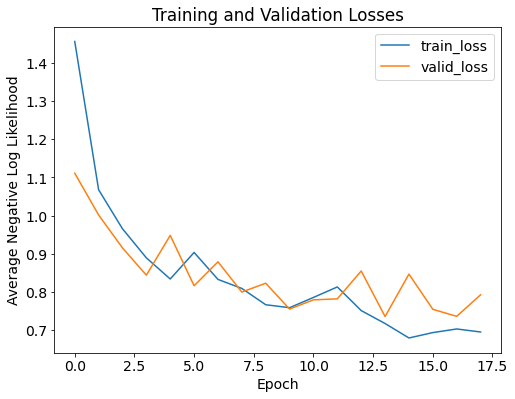

In [18]:
# plot val/train loss for spectrogram model
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_lib[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show();

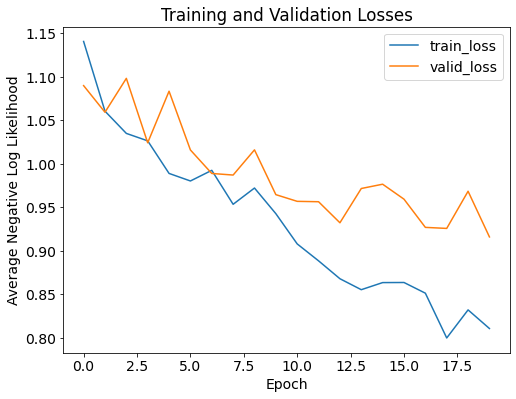

In [19]:
# plot val/train loss for chroma model
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_chrm[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show();

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

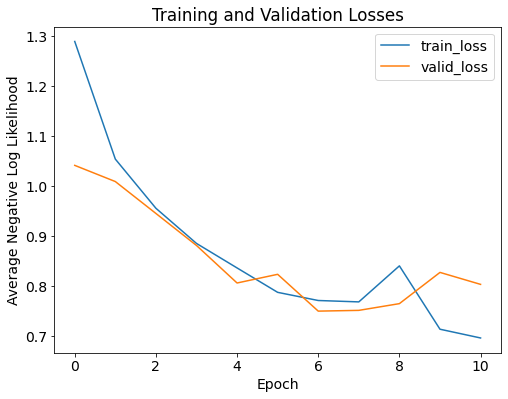

In [20]:
# # plot val/train loss for mfcc model
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_mfcc[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

In [24]:
# save state dict in trained models folder also
torch.save(model_lib.state_dict(), './trained_models/mini_model_librosa.pt')
torch.save(model_chrm.state_dict(), './trained_models/mini_model_chroma.pt')
torch.save(model_mfcc.state_dict(), './trained_models/mini_model_mfcc.pt')